# Analysis of Models using only MIMIC Notes

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import pickle
import numpy as np
import pandas as pd

from pathlib import Path
from scipy import stats
from itertools import combinations
from tqdm import tqdm_notebook as tqdm

from utils.metrics import BinaryAvgMetrics
from utils.plots import *

In [2]:
from lr.args import args as lr_args
from rf.args import args as rf_args
from gbm.args import args as gbm_args

In [3]:
s_thresh = {
  'LR': lr_args.structured_threshold,
  'RF': rf_args.structured_threshold,
  'GBM': gbm_args.structured_threshold,
}

u_thresh = {
  'LR': lr_args.unstructured_threshold,
  'RF': rf_args.unstructured_threshold,
  'GBM': gbm_args.unstructured_threshold,
}

mm_thresh = {
  'LR': lr_args.mm_threshold,
  'RF': rf_args.mm_threshold,
  'GBM': gbm_args.mm_threshold,
}

In [4]:
path = Path('data')
workdir = path/'workdir/'
figdir = workdir/'figures'

## Functions

In [12]:
def get_mean_tprs(bams, base_fpr):
  mean_tprs = {}  
  for model, bam in bams.items():
    tprs = []  
    for i, (targs, probs) in enumerate(zip(bam.targs, bam.pos_probs)):
      fpr, tpr, _ = roc_curve(targs, probs)
      tpr = interp(base_fpr, fpr, tpr)
      tpr[0] = 0.0
      tprs.append(tpr)

    tprs = np.array(tprs)
    mean_tprs[model] = tprs.mean(axis=0)
    
  return mean_tprs

In [ ]:
def get_ensemble(ensembles, thresh, bams):  
  outputs = {}
  for ens_model in ensembles:
    key = '-'.join(ens_model)
    targs = bams[ens_model[0]].targs
    avg_thresh = np.array([thresh[model] for model in ens_model]).mean()
    max_thresh = max([thresh[model] for model in ens_model])
    probs = []
    for i in range(len(targs)):
      prob = []
      for model in ens_model:
        prob.append(bams[model].pos_probs[i])
      probs.append(np.stack(prob))

    avg_probs = [probs.mean(axis=0) for probs in probs]
    max_probs = [probs.max(axis=0) for probs in probs]

    avg_preds = [(probs > avg_thresh).astype(np.int64) for probs in avg_probs]
    max_preds = [(probs > max_thresh).astype(np.int64) for probs in max_probs]
    outputs[f'AVG-{key}'] = (targs, avg_preds, avg_probs, avg_thresh)
    outputs[f'MAX-{key}'] = (targs, max_preds, max_probs, max_thresh)
    
  return outputs

In [ ]:
def do_ttest(bams, model1, model2, metric):  
  if metric == 'sensitivity':
    x1 = bams[model1].sensitivities()
    x2 = bams[model2].sensitivities()
  elif metric == 'specificity':
    x1 = bams[model1].specificities()
    x2 = bams[model2].specificities()
  elif metric == 'ppv':
    x1 = bams[model1].ppvs()
    x2 = bams[model2].ppvs()
  elif metric == 'auroc':
    x1 = bams[model1].aurocs()
    x2 = bams[model2].aurocs()
  elif metric == 'npv':
    x1 = bams[model1].npvs()
    x2 = bams[model2].npvs()
  elif metric == 'f1':    
    x1 = bams[model1].f1s()
    x2 = bams[model2].f1s()

  t, p = stats.ttest_ind(x1, x2)
  return np.round(t, 2), max(np.round(p, 2), 0.001)

## Ensembles

In [ ]:
subset = 'u+s'

In [ ]:
if subset == 's':
  thresh = s_thresh
elif subset == 'u':
  thresh = u_thresh
elif subset == 'u+s':
  thresh = mm_thresh

models = ['LR', 'RF', 'GBM']
bams = {}

for model in models:
  with open(workdir/model.lower()/f'{subset}_preds.pkl', 'rb') as f:
    targs = pickle.load(f)
    probs = pickle.load(f)
    preds = pickle.load(f)
  bams[model] = BinaryAvgMetrics(targs, preds, [prob[:, 1] for prob in probs])

In [ ]:
# ens_models = [
#   ['lr', 'rf'],
#   ['lr', 'gbm'],
#   ['rf', 'gbm'],  
#   ['lr', 'rf', 'gbm'],
# ]

ens_models = [m for m in sum([list(map(list, combinations(models, i))) for i in range(len(models) + 1)], []) if len(m) > 1]

In [ ]:
ensembles = get_ensemble(ens_models, thresh, bams)

for model, vals in ensembles.items():
  bams[model] = BinaryAvgMetrics(*vals[:-1])  

# remove the pair maxes
bams.pop('MAX-LR-RF')
bams.pop('MAX-LR-GBM')
bams.pop('MAX-RF-GBM')
bams['AVG-ALL'] = bams.pop('AVG-LR-RF-GBM')
bams['MAX-ALL'] = bams.pop('MAX-LR-RF-GBM')

In [ ]:
final_metrics = {}

for key in bams.keys():
  final_metrics[key] = []
  for i in range(len(bams[key].get_main_avg_metrics())):
    final_metrics[key].append(bams[key].get_main_avg_metrics().iloc[i]['Value'])

In [ ]:
final_metrics = pd.DataFrame(final_metrics, index=['sensitivity', 'specificity', 'ppv', 'auroc']).transpose()

best_models = pd.DataFrame([(final_metrics[metric].idxmax(), final_metrics[metric].max()) for metric in final_metrics], columns=['model', 'value'], index=['sensitivity', 'specificity', 'ppv', 'auroc'])

In [ ]:
models = list(final_metrics.index)
metrics = list(final_metrics.columns)

In [ ]:
ttests = {}

for m1, m2 in combinations(models, 2):  
  ttests[f'{m1}:{m2}'] = {}
  for metric in metrics:
    ttests[f'{m1}:{m2}'][metric] = do_ttest(bams, m1, m2, metric)

ttests = pd.DataFrame(ttests).transpose()

In [ ]:
pickle.dump(bams, open(workdir/f'{subset}_bams.pkl', 'wb'))
final_metrics.to_csv(workdir/f'{subset}_metrics.csv', float_format='%.3f')
best_models.to_csv(workdir/f'{subset}_best_models.csv', float_format='%.3f')
ttests.to_csv(workdir/f'{subset}_ttests.csv')

## Results

In [ ]:
subsets = ['s', 'u', 'u+s']
ptr = iter(subsets)

best_all = {}

### Best Models

In [ ]:
subset = next(ptr)
best_all[subset] = {}
print(subset)

In [ ]:
bams = pickle.load(open(workdir/f'{subset}_bams.pkl', 'rb'))
final_metrics = pd.read_csv(workdir/f'{subset}_metrics.csv', index_col=0)
best_models = pd.read_csv(workdir/f'{subset}_best_models.csv', index_col=0)
ttests = pd.read_csv(workdir/f'{subset}_ttests.csv', index_col=0)

best_models.reset_index(inplace=True)
best_models

In [ ]:
for i, row in best_models.iterrows():
  if i > 3: break
  best_all[subset][row['index']] = (row['model'], row['value'])

### Best ttests

In [ ]:
s_bams = pickle.load(open(workdir/f's_bams.pkl', 'rb'))
u_bams = pickle.load(open(workdir/f'u_bams.pkl', 'rb'))
us_bams = pickle.load(open(workdir/f'u+s_bams.pkl', 'rb'))

mets = ['sensitivity', 'specificity', 'ppv', 'auroc']
itr = iter(mets)

In [ ]:
met = next(itr)
print(met)

if met == 'sensitivity':
  s_met = s_bams[best_all['s'][met][0]].sensitivities()
  u_met = u_bams[best_all['u'][met][0]].sensitivities()
  us_met = us_bams[best_all['u+s'][met][0]].sensitivities()
elif met == 'specificity':
  s_met = s_bams[best_all['s'][met][0]].specificities()
  u_met = u_bams[best_all['u'][met][0]].specificities()
  us_met = us_bams[best_all['u+s'][met][0]].specificities()
if met == 'ppv':
  s_met = s_bams[best_all['s'][met][0]].ppvs()
  u_met = u_bams[best_all['u'][met][0]].ppvs()
  us_met = us_bams[best_all['u+s'][met][0]].ppvs()
if met == 'auroc':
  s_met = s_bams[best_all['s'][met][0]].aurocs()
  u_met = u_bams[best_all['u'][met][0]].aurocs()
  us_met = us_bams[best_all['u+s'][met][0]].aurocs()

_, p_s_u = stats.ttest_ind(s_met, u_met)
_, p_u_us = stats.ttest_ind(u_met, us_met)
_, p_s_us = stats.ttest_ind(s_met, us_met)

print(f"p (structured - unstructured): {max(p_s_u, 0.001)}")
print(f"p (unstructured - mm): {max(p_u_us, 0.001)}")
print(f"p (structured - mm): {max(p_s_us, 0.001)}")

## Box Plot

In [5]:
plot_dfs = []
for subset, label in [('s', 'Vitals (S)'), ('u', 'Notes (U)'), ('u+s', 'Notes & Vitals (U+S)')]:
  bams = pickle.load(open(workdir/f'{subset}_bams.pkl', 'rb'))
  final_metrics = pd.read_csv(workdir/f'{subset}_metrics.csv', index_col=0)
  best_models = pd.read_csv(workdir/f'{subset}_best_models.csv', index_col=0)
  ttests = pd.read_csv(workdir/f'{subset}_ttests.csv', index_col=0)

  metrics = {}
  for md in bams.keys():
    df = pd.DataFrame()
    for k, m in bams[md].yield_metrics():
      df[k] = m
    df['Model'] = md
    cols = list(df.columns)
    cols = [cols[-1]] + cols[:-1]
    df = df[cols]
    metrics[md] = df

  plot_df = pd.concat(metrics.values())
  plot_df['Label'] = label
  plot_dfs.append(plot_df)

In [6]:
plot_df = pd.concat(plot_dfs)
plot_df[['Sensitivity', 'Specificity', 'PPV', 'AUC']] = plot_df[['Sensitivity', 'Specificity', 'PPV', 'AUC']] * 100
plot_df.shape

(2400, 8)

In [7]:
mets = ['Sensitivity', 'Specificity', 'PPV', 'AUC']
met_itr = iter(mets)

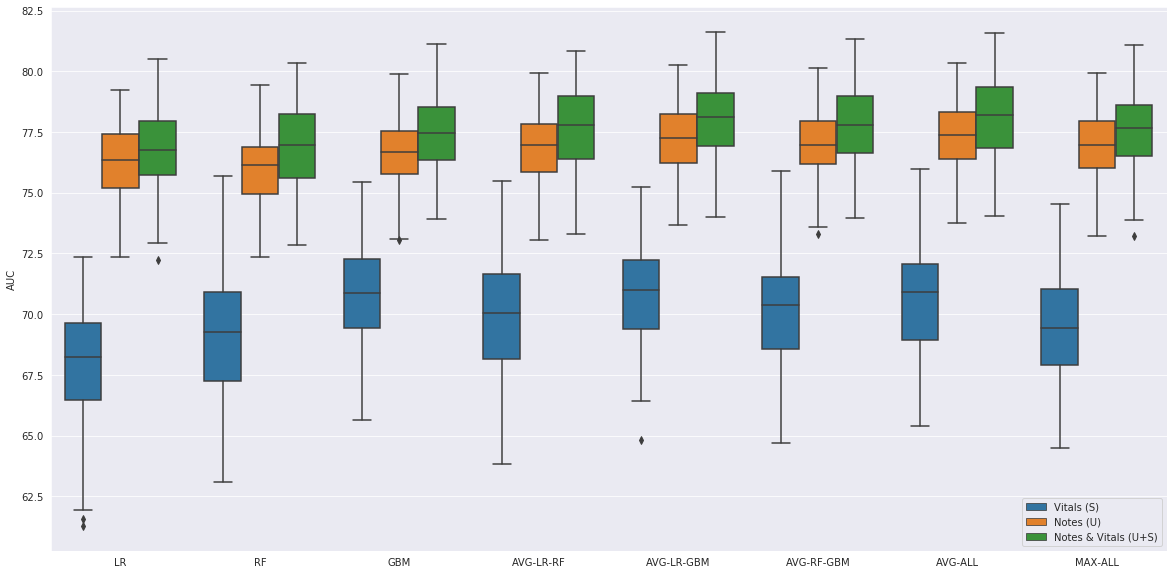

In [11]:
met = next(met_itr)

fig, ax = plt.subplots(1,1,figsize=(20,10))
sns.boxplot(x='Model', y=met, hue='Label', data=plot_df, ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:])
# for i in range(7): plt.axvline(x=i+0.5, ls='-.', color='black')
ax.set_xlabel('')

fig.savefig(figdir/f'{met.lower()}_box_plot.pdf', dpi=300, box_inches='tight', pad_inches=0)

## Mean AUC

In [26]:
subsets = ['s', 'u', 'u+s']
sub_itr = iter(subsets)

In [41]:
subset = next(sub_itr)

bams = pickle.load(open(workdir/f'{subset}_bams.pkl', 'rb'))
final_metrics = pd.read_csv(workdir/f'{subset}_metrics.csv', index_col=0)
best_models = pd.read_csv(workdir/f'{subset}_best_models.csv', index_col=0)
ttests = pd.read_csv(workdir/f'{subset}_ttests.csv', index_col=0)

dess = ['main_', 'all_']
des_itr = iter(dess)

In [45]:
des = next(des_itr)

if des == 'main_':
  plot_bams = {k: bams[k] for k in bams.keys() if '-' not in k}
  des = ''  
  names = plot_bams.keys()
  aucs = [model.auroc_avg() for _, model in plot_bams.items()]
  legends = [f'{model} ({auc})' for model, auc in zip(names, aucs)]
elif des == 'all_':
  plot_bams = bams
  names = plot_bams.keys()
  aucs = [model.auroc_avg() for _, model in plot_bams.items()]
  legends = [f'{model} ({auc})' for model, auc in zip(names, aucs)]
  
legends  

['LR (0.768)',
 'RF (0.77)',
 'GBM (0.775)',
 'AVG-LR-RF (0.777)',
 'AVG-LR-GBM (0.78)',
 'AVG-RF-GBM (0.778)',
 'AVG-ALL (0.781)',
 'MAX-ALL (0.776)']

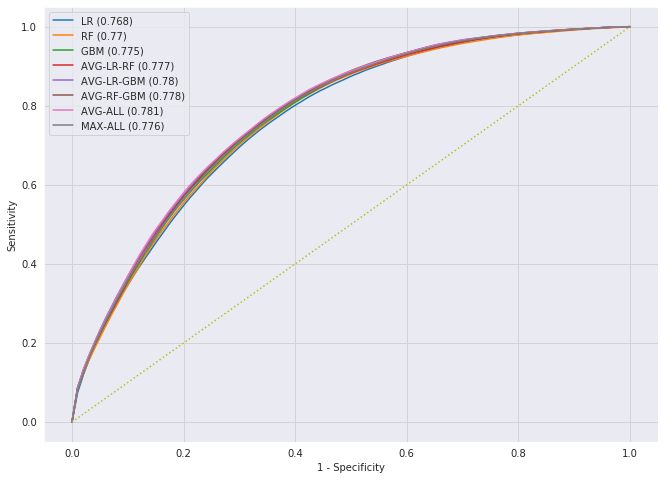

In [46]:
base_fpr = np.linspace(0, 1, 100)
mean_tprs = get_mean_tprs(plot_bams, base_fpr)

fig, ax = plt.subplots(1, 1, figsize=(11, 8))
for i, (model, mean_tpr) in enumerate(mean_tprs.items()):
  ax.plot(base_fpr, mean_tpr)
ax.plot([0, 1], [0, 1], linestyle=':')  
ax.grid(b=True, which='major', color='#d3d3d3', linewidth=1.0)
ax.grid(b=True, which='minor', color='#d3d3d3', linewidth=0.5)
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1 - Specificity')
ax.legend(legends)

In [47]:
fig.savefig(figdir/f'{subset}_{des}mean_auc.pdf', dpi=300)